<a href="https://colab.research.google.com/github/MiguelEuripedes/embedded_AI/blob/main/Projects/first_image_classifier/cnn_classifier/preprocessing_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your first Image Classifier: Using CNN to Classify Images

## Pre-processing

The purpose of this dataset is to correctly classify an image as containing a dog, cat, or panda. Containing only 3,000 images, the Animals dataset is meant to be another **introductory** dataset that we can quickly train a CNN model and obtain a comparative results with the previous KNN model.

Let's take the following steps:

1. Fetch Data (reuse of the previous project)
2. Pre-processing
3. Clean data

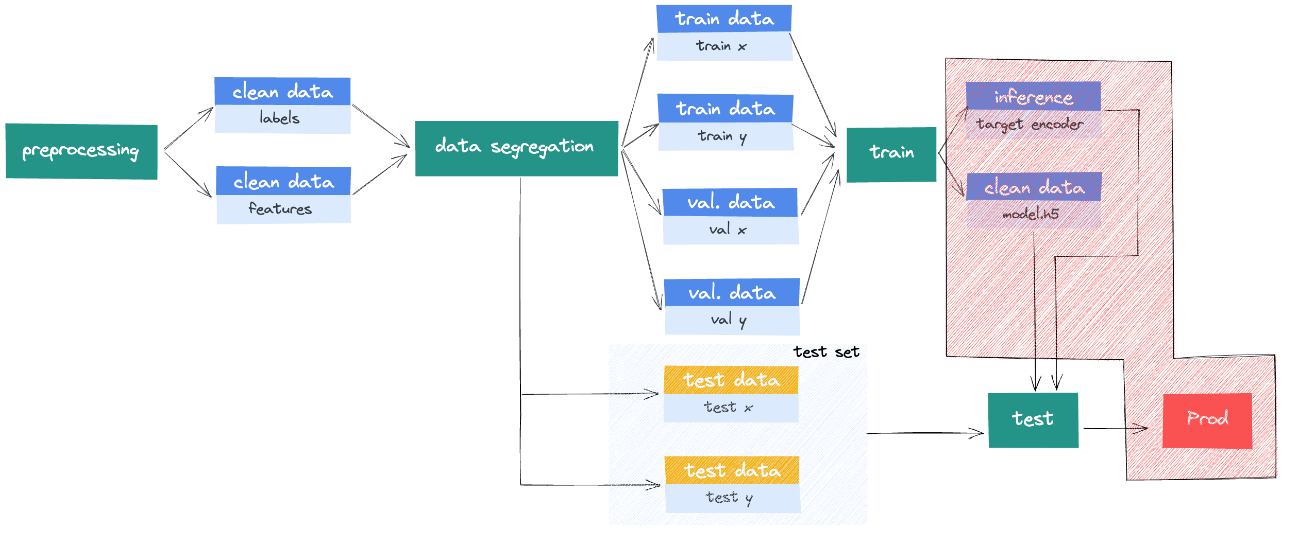

### Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:

* **pip install wandb** – Install the W&B library
* **import wandb** – Import the wandb library
* **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 5.3 MB/s 
     |████████████████████████████████| 162 kB 44.3 MB/s 
     |████████████████████████████████| 182 kB 45.6 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 162 kB 47.1 MB/s 
     |████████████████████████████████| 158 kB 48.6 MB/s 
     |████████████████████████████████| 157 kB 43.9 MB/s 
     |████████████████████████████████| 157 kB 4.4 MB/s 
     |████████████████████████████████| 157 kB 49.9 MB/s 
     |████████████████████████████████| 157 kB 33.6 MB/s 
     |████████████████████████████████| 157 kB 45.7 MB/s 
     |████████████████████████████████| 157 kB 57.3 MB/s 
     |████████████████████████████████| 157 kB 72.7 MB/s 
     |████████████████████████████████| 156 kB 57.7 MB/s 


**Import Packages**

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

### Step 02: Fetch Data

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "dataset": "animals",
    "project_name": "first_image_classifier",
    "artifact_name": "animals_raw_data:latest",
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="euripedes",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact animals_raw_data:latest, 187.97MB. 3000 files... 
wandb:   3000 of 3000 files downloaded.  
Done. 0:0:28.9
16-10-2022 19:04:50 Path: ./artifacts/animals_raw_data:v0


In [ ]:
run.finish()

### Step 03 - Clean Data

**Project Config**

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "features": "clean_features",
    "target": "labels",
    "project_name": "cnn_classifier"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="euripedes",project=args["project_name"], job_type="preprocessing")

**Loader and Preprocessing Classes**

Source code based on **Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019** [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [ ]:
# a basic simple preprocessor that resize a image

class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),interpolation=self.inter)


In [ ]:
# Rearrange the dimension of an image and return a numpy array
# Default dimension is (heigh, width, channel)

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return tf.keras.utils.img_to_array(image, data_format=self.dataFormat)

In [ ]:
# Building an image loader
class SimpleDatasetLoader:
  def __init__(self, preprocessors=None, logger=None):
		# store the image preprocessor
    self.preprocessors = preprocessors
    self.logger = logger

		# if the preprocessors are None, initialize them as an
		# empty list
    if self.preprocessors is None:
      self.preprocessors = []

  def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
    data = []
    labels = []

		# loop over the input images
    for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			# e.g "img example: ./artifacts/animals_raw_data:v0/dogs/dogs_00892.jpg"
			# imagePath.split(os.path.sep)[-2] will return "dogs"
      image = cv2.imread(imagePath)
      label = imagePath.split(os.path.sep)[-2]

      # check to see if our preprocessors are not None
      if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
        for p in self.preprocessors:
          image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
      data.append(image)
      labels.append(label)
   
			# show an update every `verbose` images
      if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        logger.info("[INFO] processed {}/{}".format(i + 1,len(imagePaths)))

		# return a tuple of the data and labels
    return (np.array(data), np.array(labels))

**Cleaning**

In [ ]:
# grab the list of images that we'll be describing
logger.info("[INFO] preprocessing images...")
imagePaths = list(paths.list_images(data_dir))

# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

# show some information on memory consumption of the images
logger.info("[INFO] features matrix: {:.1f}MB".format(data.nbytes / (1024 * 1024)))
logger.info("[INFO] labels vector: {:.1f}MB".format(labels.nbytes / (1024 * 1024)))
logger.info("[INFO] features shape: {}, labels shape: {}".format(data.shape,labels.shape))

16-10-2022 19:05:16 [INFO] preprocessing images...
16-10-2022 19:05:18 [INFO] processed 500/3000
16-10-2022 19:05:19 [INFO] processed 1000/3000
16-10-2022 19:05:21 [INFO] processed 1500/3000
16-10-2022 19:05:23 [INFO] processed 2000/3000
16-10-2022 19:05:26 [INFO] processed 2500/3000
16-10-2022 19:05:29 [INFO] processed 3000/3000
16-10-2022 19:05:29 [INFO] features matrix: 70.3MB
16-10-2022 19:05:29 [INFO] labels vector: 0.1MB
16-10-2022 19:05:29 [INFO] features shape: (3000, 32, 32, 3), labels shape: (3000,)


### Dump the artifacts to disk and upload to W&B

In [ ]:
# Save the feature artifacts using joblib
joblib.dump(data, args["features"])

# Save the target using joblib
joblib.dump(labels, args["target"])

logger.info("Dumping the clean data artifacts to disk")

16-10-2022 19:05:36 Dumping the clean data artifacts to disk


In [ ]:
# clean data artifact
artifact = wandb.Artifact(args["features"],
                          type="CLEAN_DATA",
                          description="A json file representing the clean features data"
                          )

logger.info("Logging clean data artifact")
artifact.add_file(args["features"])
run.log_artifact(artifact)

16-10-2022 19:05:38 Logging clean data artifact


In [ ]:
# clean label artifact
artifact = wandb.Artifact(args["target"],
                          type="CLEAN_DATA",
                          description="A json file representing the clean target"
                          )

logger.info("Logging clean target artifact")
artifact.add_file(args["target"])
run.log_artifact(artifact)

16-10-2022 19:05:41 Logging clean target artifact


In [ ]:
run.finish()